In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
df_raw = pd.read_csv("annthyroid.csv", header=None)
df_raw.loc[df_raw[21] == -1, 21] = 0
device = "cpu"
y = pd.get_dummies(df_raw.iloc[:,-1])
y = torch.Tensor(y.values).to(device)
x = df_raw.iloc[:,:-1]
x = torch.Tensor(x.values).to(device)
num_split = int(len(x) * 0.8)
print(num_split)
x_train = x[:num_split,:]
x_test = x[num_split:,:]
y_train = y[:num_split,:]
y_test = y[num_split:,:]

5672


In [3]:
df_raw[21].value_counts()

0       1
1       1
2       1
3       1
4       1
       ..
7085    1
7086    0
7087    1
7088    1
7089    1
Name: 21, Length: 7090, dtype: int64

In [4]:
x_train_p_list = []
y_train_p_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_p_list.append(x_train[i])
        y_train_p_list.append(y_train[i])
#print(x_train_M_list)
y_train_p = torch.stack(y_train_p_list)
x_train_p = torch.stack(x_train_p_list)
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([1.,0.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
print(len(x_train_p))
print(len(x_train_n))

5243
429


In [5]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=21):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var
    
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [6]:
num_features = 8
model = VariationalAutoencoder(num_features=num_features)
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 100

In [7]:
custom_dataset_x_train_n = AutoencoderDataset(x_train_n)

train_loader = DataLoader(
    custom_dataset_x_train_n,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [8]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "variational-autoencoder_annthyroid_n.pth")

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.17it/s, loss=2.16]


Ave Loss: 7.418554162979126
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.68it/s, loss=1.24]


Ave Loss: 4.5211385726928714
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.94it/s, loss=0.768]


Ave Loss: 2.2702789306640625
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.29it/s, loss=0.637]


Ave Loss: 1.4664002537727356
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.10it/s, loss=0.475]


Ave Loss: 1.2267260015010835
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.79it/s, loss=0.403]


Ave Loss: 0.6462174594402313
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.62it/s, loss=0.367]


Ave Loss: 0.7174904406070709
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.37it/s, loss=0.328]


Ave Loss: 0.4413904011249542
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.67it/s, loss=0.313]


Ave Loss: 0.4428300201892853
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.10it/s, loss=0.293]


Ave Loss: 0.3634635865688324
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.65it/s, loss=0.28]


Ave Loss: 0.3364761769771576
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 83.32it/s, loss=0.265]


Ave Loss: 0.31302127838134763
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.53it/s, loss=0.267]


Ave Loss: 0.2972891807556152
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.64it/s, loss=0.255]


Ave Loss: 0.28476043343544005
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.37it/s, loss=0.262]


Ave Loss: 0.2781390309333801
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.32it/s, loss=0.25]


Ave Loss: 0.27014966011047364
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.26it/s, loss=0.241]


Ave Loss: 0.26195994317531585
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.46it/s, loss=0.244]


Ave Loss: 0.25895039141178133
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.97it/s, loss=0.244]


Ave Loss: 0.2550617605447769
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.46it/s, loss=0.239]


Ave Loss: 0.25190945863723757
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.70it/s, loss=0.235]


Ave Loss: 0.2474721699953079
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.25it/s, loss=0.237]


Ave Loss: 0.2463947355747223
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 51.02it/s, loss=0.232]


Ave Loss: 0.2428326576948166
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.29it/s, loss=0.233]


Ave Loss: 0.24338837265968322
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56.18it/s, loss=0.238]


Ave Loss: 0.24198373258113862
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.65it/s, loss=0.231]


Ave Loss: 0.23870496749877929
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.13it/s, loss=0.233]


Ave Loss: 0.23855308294296265
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.79it/s, loss=0.227]


Ave Loss: 0.23569517731666564
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.44it/s, loss=0.229]


Ave Loss: 0.23560868799686432
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.33it/s, loss=0.236]


Ave Loss: 0.23708131313323974
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 57.04it/s, loss=0.237]


Ave Loss: 0.2366696000099182
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.53it/s, loss=0.23]


Ave Loss: 0.23450731635093688
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s, loss=0.224]


Ave Loss: 0.23347449600696563
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s, loss=0.231]


Ave Loss: 0.2332501530647278
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.31it/s, loss=0.229]


Ave Loss: 0.23312947750091553
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.32it/s, loss=0.232]


Ave Loss: 0.23362947404384612
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.53it/s, loss=0.23]


Ave Loss: 0.23111252188682557
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.96it/s, loss=0.238]


Ave Loss: 0.23341498374938965
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.67it/s, loss=0.225]


Ave Loss: 0.23074306845664977
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.44it/s, loss=0.23]

Ave Loss: 0.2312683343887329


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.13it/s, loss=0.231]


Ave Loss: 0.2307778626680374
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.37it/s, loss=0.228]


Ave Loss: 0.23062385022640228
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.97it/s, loss=0.232]


Ave Loss: 0.2294635683298111
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.76it/s, loss=0.231]


Ave Loss: 0.2299678534269333
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.37it/s, loss=0.227]


Ave Loss: 0.22950348556041716
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.02it/s, loss=0.225]


Ave Loss: 0.22817685306072236
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.53it/s, loss=0.222]


Ave Loss: 0.2280937284231186
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.53it/s, loss=0.226]


Ave Loss: 0.2284759372472763
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.67it/s, loss=0.228]


Ave Loss: 0.22872314155101775
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.49it/s, loss=0.225]


Ave Loss: 0.22791527211666107
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.36it/s, loss=0.23]


Ave Loss: 0.2281493842601776
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.49it/s, loss=0.235]


Ave Loss: 0.23008341193199158
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.76it/s, loss=0.226]


Ave Loss: 0.22858638167381287
Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.91it/s, loss=0.231]


Ave Loss: 0.22936731278896333
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.227]


Ave Loss: 0.22767476439476014
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.45it/s, loss=0.234]


Ave Loss: 0.2291560709476471
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.13it/s, loss=0.226]


Ave Loss: 0.2278114765882492
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.96it/s, loss=0.225]


Ave Loss: 0.22680168747901916
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.229]


Ave Loss: 0.22730130851268768
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.67it/s, loss=0.222]


Ave Loss: 0.2258989304304123
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.63it/s, loss=0.227]


Ave Loss: 0.2267083376646042
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.42it/s, loss=0.228]


Ave Loss: 0.22602740228176116
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.65it/s, loss=0.224]


Ave Loss: 0.22641009986400604
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 73.53it/s, loss=0.228]


Ave Loss: 0.2271447777748108
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.44it/s, loss=0.227]


Ave Loss: 0.22608909904956817
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.43it/s, loss=0.221]


Ave Loss: 0.2257167398929596
Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.63it/s, loss=0.226]


Ave Loss: 0.2265831083059311
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.13it/s, loss=0.225]


Ave Loss: 0.22755811512470245
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.226]


Ave Loss: 0.22833252251148223
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.63it/s, loss=0.231]


Ave Loss: 0.2294094979763031
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.42it/s, loss=0.228]


Ave Loss: 0.22863772809505462
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.44it/s, loss=0.225]


Ave Loss: 0.22841026782989501
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.75it/s, loss=0.226]


Ave Loss: 0.2301537424325943
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.79it/s, loss=0.228]


Ave Loss: 0.22912325859069824
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67.57it/s, loss=0.229]


Ave Loss: 0.23397083282470704
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.54it/s, loss=0.226]


Ave Loss: 0.23627910017967224
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.11it/s, loss=0.231]


Ave Loss: 0.24091262221336365
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.46it/s, loss=0.231]


Ave Loss: 0.24207778573036193
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 52.34it/s, loss=0.226]


Ave Loss: 0.2386414587497711
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.43it/s, loss=0.225]


Ave Loss: 0.2328348070383072
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.228]


Ave Loss: 0.2294059544801712
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.42it/s, loss=0.224]


Ave Loss: 0.23208918273448945
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 60.97it/s, loss=0.228]


Ave Loss: 0.23995103538036347
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.229]


Ave Loss: 0.24883576929569245
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.12it/s, loss=0.223]


Ave Loss: 0.2532298117876053
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.96it/s, loss=0.223]


Ave Loss: 0.2518422693014145
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.76it/s, loss=0.226]


Ave Loss: 0.2485971361398697
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67.08it/s, loss=0.226]


Ave Loss: 0.24238089323043824
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.92it/s, loss=0.231]


Ave Loss: 0.24073219895362855
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.46it/s, loss=0.225]


Ave Loss: 0.23915480375289916
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.45it/s, loss=0.227]


Ave Loss: 0.23647256791591645
Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.43it/s, loss=0.224]


Ave Loss: 0.23247685432434081
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.12it/s, loss=0.231]


Ave Loss: 0.23485834896564484
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.80it/s, loss=0.223]


Ave Loss: 0.23928442001342773
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.42it/s, loss=0.226]


Ave Loss: 0.2485243409872055
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.35it/s, loss=0.225]


Ave Loss: 0.2507071942090988
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.56it/s, loss=0.222]


Ave Loss: 0.24337044954299927
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.79it/s, loss=0.232]


Ave Loss: 0.23600224852561952
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.63it/s, loss=0.225]


Ave Loss: 0.23049634993076323
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.62it/s, loss=0.228]

Ave Loss: 0.23160341680049895


In [9]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

C:\Users\JMARANAN\AppData\Local\Temp\ipykernel_16108\2407897311.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


In [10]:
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
for i in range(len(x_train_p)-len(x_train_n)):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    # print(reconstruction)
    x_train_n_list.append(reconstruction[0])
    y_train_n_list.append(y_train_n_list[0])
x_train_n = torch.stack(x_train_n_list)
y_train_n = torch.stack(y_train_n_list)
print(len(x_train_p))
print(len(x_train_n))
print(len(y_train_p))
print(len(y_train_n))
x_train_ext = torch.cat((x_train_p, x_train_n), 0)
y_train_ext = torch.cat((y_train_p, y_train_n), 0)
print(len(x_train_ext))
print(len(y_train_ext))

5243
5243
5243
5243
10486
10486


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 500) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(500, 10)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        
        x = self.hidden_layer_2(x)
        
        y = self.output_layer(x)
        
        y = self.activation(y)
        
        return y
    
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def one_hot_encoding(nd_array):
        one_hot_encoding_predictions = nd_array.clone().detach()

        for i in range(len(nd_array)):
            max_pred = max(nd_array[i])

            for j in range(len(nd_array[i])):
                one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

        return one_hot_encoding_predictions
    
def accuracy_test(y_test, y_pred):
    y_test = y_test.clone().detach()
    y_pred = y_pred.clone().detach()
    true_p = 0
    for i in range(len(y_test)):
        if y_test[i].equal(y_pred[i]):
            print(y_pred[i])
            true_p += 1
    return true_p / len(y_test)

def train_fn_eval(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 91.33it/s, loss=0.000205]


Ave Loss: 0.023699302699727316
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 118.87it/s, loss=0.000114]


Ave Loss: 0.0001464595258723767
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 118.84it/s, loss=6.96e-5]


Ave Loss: 8.46638896508098e-05
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 116.59it/s, loss=4.62e-5]


Ave Loss: 5.374843004531049e-05
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 110.41it/s, loss=3.27e-5]


Ave Loss: 3.6761891429445575e-05
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 96.33it/s, loss=2.42e-5]


Ave Loss: 2.6568194031521367e-05
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 119.20it/s, loss=1.86e-5]


Ave Loss: 2.0010758895036164e-05
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 114.50it/s, loss=1.47e-5]


Ave Loss: 1.5557714894904556e-05
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 116.04it/s, loss=1.18e-5]


Ave Loss: 1.240161190729677e-05
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 100.00it/s, loss=9.7e-6]


Ave Loss: 1.0086230620453577e-05
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 102.54it/s, loss=8.09e-6]


Ave Loss: 8.339270901896746e-06
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 103.05it/s, loss=6.83e-6]


Ave Loss: 6.9911256105115175e-06
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 104.89it/s, loss=5.82e-6]


Ave Loss: 5.928515513785117e-06
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 108.88it/s, loss=5.01e-6]


Ave Loss: 5.077292245827959e-06
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 117.16it/s, loss=4.35e-6]


Ave Loss: 4.3858661012477355e-06
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 109.87it/s, loss=3.8e-6]


Ave Loss: 3.816674979177714e-06
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 78.92it/s, loss=3.34e-6]


Ave Loss: 3.3431113825783886e-06
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 112.75it/s, loss=2.95e-6]


Ave Loss: 2.9456884952932817e-06
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 116.14it/s, loss=2.62e-6]


Ave Loss: 2.60792265916756e-06
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 115.13it/s, loss=2.34e-6]


Ave Loss: 2.320230074864022e-06


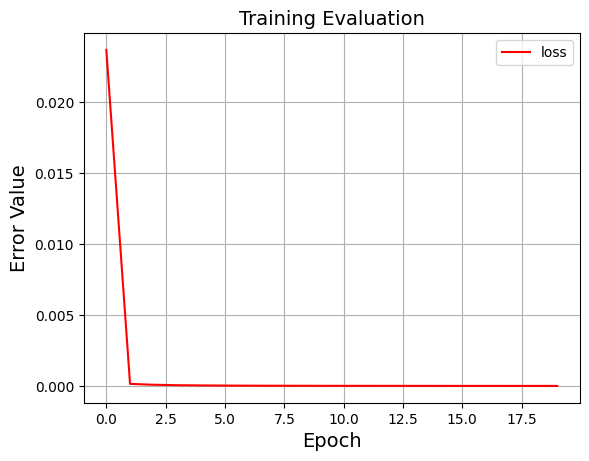

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

0.9308885754583921

In [12]:
model_ext = NeuralNetwork(21, 2)

optimizer = optim.Adam(model_ext.parameters(), lr=learning_rate)
x_train_ext = x_train_ext.clone().detach()
y_train_ext = y_train_ext.clone().detach()
custom_dataset_ext = MyCustomDataset(x=x_train_ext, y=y_train_ext)

train_loader_ext = DataLoader(
    custom_dataset_ext,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

losses = []
epochs = 20

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_eval(
        train_loader_ext,
        model_ext,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model_ext.state_dict() }

    torch.save(state, "model_annthyroid_ext.pth")
    
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

y_pred = one_hot_encoding(model_ext.forward(x_test))
accuracy_test(y_test, y_pred)

In [13]:
y_pred

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])